In [1]:
import scanpy as sc
import squidpy as sq
import os
import anndata as ad
import tqdm
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd

import skimage.exposure
import numpy as np

/Users/hannah.spitzer/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/napari/__init__.py:44: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [2]:
# get spatial dataset including hires tissue image
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

## Prepare features and clusters
save calculated clusters for later use

In [5]:
# define different feature calculation combinations
params = {
    # all features, corresponding only to tissue underneath spot
    'features_orig': 
    {'features': 'summary',
    'size': 1,
    'scale': 1.0,
    'mask_circle': True},
    # summary and histogram features with a bit more context, original resolution
    'features_context': 
    {'features': 'summary',
    'size': 2,
    'scale': 1.0},
    # summary and histogram features with more context and at lower resolution
    'features_lowres' :
    {'features': 'summary',
    'size': 4,
    'scale': 0.25}
}

In [6]:
# extract features with the different parameters in a loop
for feature_name, cur_params in tqdm.tqdm(params.items()):
    # features will be saved in `adata.obsm[feature_name]`
    sq.im.calculate_image_features(adata, img, key_added=feature_name, n_jobs=4, **cur_params)

100%|██████████| 3/3 [00:45<00:00, 15.05s/it]


In [7]:
# fill nans
adata.obsm['features_orig'].fillna(value=0, inplace=True)
# combine features in one dataframe
adata.obsm['features'] = pd.concat([adata.obsm[f] for f in params.keys()], axis='columns')
# make sure that we have no duplicated feature names in the combined table
adata.obsm['features'].columns = ad.utils.make_index_unique(adata.obsm['features'].columns)

In [8]:
# helper function returning a clustering
def cluster_features(features, like=None):
    """Calculate leiden clustering of features.
    
    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1]-1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)
    
    return adata.obs['leiden']

In [9]:
# cluster features
adata.obs['features_cluster'] = cluster_features(adata.obsm['features'])

# save features clusters to always have the same clusters
adata.obs['features_cluster'].to_csv('features_cluster.csv')

## Plot and save figs

In [3]:
# load features clusters in adata
adata.obs['features_cluster'] = pd.read_csv('features_cluster.csv', index_col=0)
adata.obs['features_cluster'] = adata.obs['features_cluster'].astype('category')

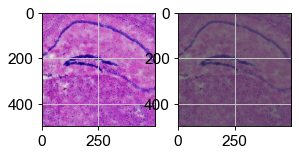

In [39]:
# make hne image a bit brighter
#img = adata.uns['spatial']['V1_Adult_Mouse_Brain']['images']['hires']
p2, p98 = np.percentile(img, (0.5, 99.5))
img_rescale = skimage.exposure.rescale_intensity(img, in_range=(p2, p98))

fig, axes = plt.subplots(1,2)
axes[0].imshow(img_rescale[500:1000,500:1000])
axes[1].imshow(img[500:1000,500:1000])

adata.uns['spatial']['V1_Adult_Mouse_Brain']['images']['hires'] = img_rescale

In [40]:
# plotting settings
sc.settings.dpi = 300
sc.set_figure_params(facecolor="white", fontsize=14)
# fontsize sets the size of the title

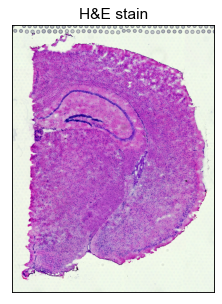

In [94]:
fig, ax = plt.subplots(
    figsize=(3, 5),
)
# plot hne
sc.pl.spatial(
    adata,
    color=None,
    img_key='hires',
    ax=ax,
    title='H&E stain',
    #legend_loc=False,
    show=False
)
ax.axes.xaxis.label.set_visible(False)
ax.axes.yaxis.label.set_visible(False)
# save figure
plt.tight_layout()
plt.savefig('figures/spatial_hne.png', dpi=300, bbox_inches='tight')

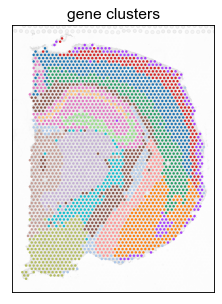

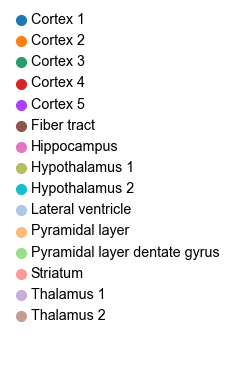

In [95]:
# plot gene clusters
fig, ax = plt.subplots(figsize=(3, 5))
sc.pl.spatial(
    adata,
    color='cluster',
    img_key='hires',
    ax=ax,
    alpha_img=0.2,
    bw=True,
    title='gene clusters',
    #legend_loc=False,
    show=False,
)
#ax.set_facecolor((0.75,0.75,0.75))
ax.axes.xaxis.label.set_visible(False)
ax.axes.yaxis.label.set_visible(False)
# get legend colors to plot later
colors, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
# save figure
plt.tight_layout()
plt.savefig('figures/spatial_cluster.png', dpi=300, bbox_inches='tight')

# plot and save legend
labels = [' '.join(l.split('_')) for l in labels]

fig, ax1 = plt.subplots(1,1, figsize=(3,5))
plt.figlegend(colors, labels, frameon=False, markerscale=1.5)
ax1.axis('off')
plt.tight_layout()
plt.savefig('figures/spatial_cluster_legend.png', dpi=300, bbox_inches='tight')
plt.show()

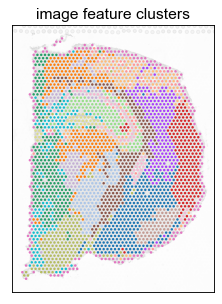

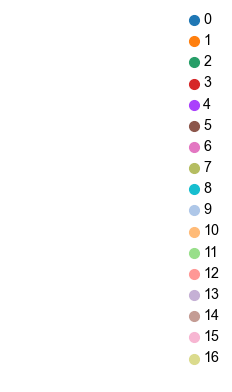

In [96]:
# plot feature clusters
fig, ax = plt.subplots(figsize=(3, 5))
sc.pl.spatial(
    adata,
    color='features_cluster',
    img_key='hires',
    ax=ax,
    alpha_img=0.2,
    bw=True,
    title='image feature clusters',
    #legend_loc=False,
    show=False
)
ax.axes.xaxis.label.set_visible(False)
ax.axes.yaxis.label.set_visible(False)
# get legend colors to plot later
colors, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
# save figure
plt.tight_layout()
plt.savefig('figures/spatial_features_cluster.png', dpi=300, bbox_inches='tight')

# plot and save legend
labels = [' '.join(l.split('_')) for l in labels]

fig, ax1 = plt.subplots(1,1, figsize=(3,5))
plt.figlegend(colors, labels, frameon=False, markerscale=1.5)
ax1.axis('off')
plt.tight_layout()
plt.savefig('figures/spatial_features_cluster_legend.png', dpi=300, bbox_inches='tight')
plt.show()

In [97]:
def plot_gene(adata, g, remove=None):
    # plot genes
    fig, ax = plt.subplots(figsize=(3, 5))
    sc.pl.spatial(
        adata,
        color=g,
        img_key='hires',
        ax=ax,
        alpha_img=0.2,
        bw=True,
        #legend_loc=False,
        show=False,
        cmap='viridis'
    )
    ax.axes.xaxis.label.set_visible(False)
    ax.axes.yaxis.label.set_visible(False)
    # remove one axis
    if remove == 'plot':
        fig.get_axes()[0].remove()
    elif remove == 'legend':
        fig.get_axes()[1].remove()
    return ax


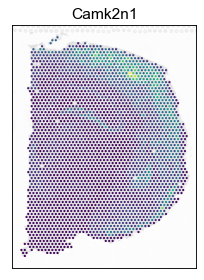

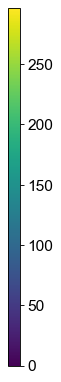

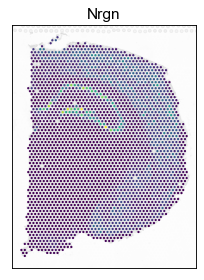

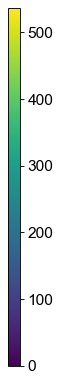

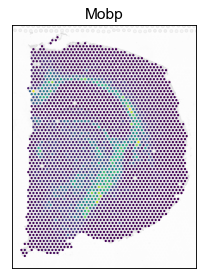

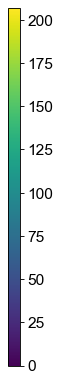

In [99]:
for g in ['Camk2n1', "Nrgn", "Mobp"]:
    # plot image
    ax = plot_gene(adata, g, remove='legend')
    plt.tight_layout()
    plt.savefig(f'figures/spatial_{g}.png', dpi=300, bbox_inches='tight')

    # plot legend
    ax = plot_gene(adata, g, remove='plot')
    plt.tight_layout()
    plt.savefig(f'figures/spatial_{g}_legend.png', dpi=300, bbox_inches='tight')